<a href="https://colab.research.google.com/github/KTM001/PDM01/blob/main/py-tensorflow/pdm01_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#transfer learning이란?
>transfer learning은 전이 학습이라고 불리며, 특정 분야에서 학습된 신경망의 일부 능력을 유사하거나 전혀 새로운 분야에서 사용되는 신경망의 학습에 이용하는 것을 말합니다.
앞쪽에 위치하고 있는 CNN 레이어를 통해서 데이터셋으로부터 받는 수많은 데이터들을 각 특징에 맞는 클래스들에게 최대한 알맞게 데이터들을 분류합니다. 이 과정에서 만약에 데이터의 수에 비해서 과도하게 CNN 레이어 층을 많이 나누었다면 오히려 과대적합이 나와서 정확도가 떨어집니다. 그렇다고 레이어 수를 줄여도 정확도가 떨어집니다. 그러므로 데이터의 양을 생각해서 알맞게 레이어의 층을 넣는것이 정확도를 올리기 위해서 좋습니다. 이렇게 데이터를 나눈 후에 fine tuning을 사용하는데 fine tuning은 분류된 데이터들을 새로운 데이터를 통해서 다시 한번 분류하는 것입니다. 코드를 보시면 transfer learning과 fine tuning의 차이점을 거의 못느끼실텐데 transfer learning에서 특징을 뽑아내서 다시 한번 데이터셋에 맞게 조정하는 것이 fine tuning이기 때문에 다른 점이 거의 없습니다.

#cifar10 에 대한 TL 결과 요약
>원래 cifar10 에서 뽑아내는 50,000개의 데이터중에서 10%인 5,000개의 데이터를 뽑아내서 transfer learning을 돌린 결과 accuracy : 0.7116, val.accuracy : 0.593이 나왔으며, fine tuning을 통해 한번 더 데이터를 분류한 결과 accuracy : 0.92, val.accuracy : 0.762 가 나왔습니다. 이를 통해서 그래프로도 알 수 있다시피 처음 transfer learning을 통해 나온 정확도보다 데이터의 특징들을 통해서 한번 더 데이터를 나눈 fine tuning이 정확도가 높다는 것을 알 수 있습니다.

In [ ]:
# from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import  MobileNetV2, preprocess_input
import tensorflow.keras as keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import tensorflow as tf
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import cv2
print(tf.__version__)

2.7.0


In [ ]:
tf.keras.backend.clear_session()  # For memory

# GPU check
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("#### ", len(gpus), "Physical GPUs,",
                 len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print('#### No CUDA supported GPU in this computer.')

####  1 Physical GPUs, 1 Logical GPUs


In [ ]:
from keras.datasets import cifar10

# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [ ]:
from sklearn.model_selection import train_test_split

trainX, test_X, trainy, test_y = train_test_split(trainX,trainy,test_size=0.1,random_state=1004,stratify = trainy)

In [ ]:
test_X.shape, test_y.shape

((5000, 32, 32, 3), (5000, 1))

In [ ]:
testX.shape, testy.shape

((10000, 32, 32, 3), (10000, 1))

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
import os
# Matplotlib config
# plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='000000')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

# utility to display a row of digits with their predictions
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    true_index = n_labels[i]
    # Set x-label color: green if prediction correct and red if prediction incorrect
    plt.xlabel(classes[class_index])
    xlabel_color = "green" if n_predictions[i] == n_labels[i] else "red"
    ax.xaxis.label.set_color(xlabel_color) 
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])


In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = preprocess_input(input_images)
  return output_ims

In [ ]:
x_train = preprocess_image_input(test_X)
x_test = preprocess_image_input(testX)

In [ ]:
x_train.shape,len(x_train),x_train[4].shape

((5000, 32, 32, 3), 5000, (32, 32, 3))

In [ ]:
y_train=test_y
y_test=testy
y_train.shape,y_test.shape

((5000, 1), (10000, 1))

In [ ]:
# One-Hot-Encoding
# Use function to_categorical() to do One-Hot-Encoding
# tf.keras.utils.to_categorical
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(test_y, 10)
y_test = to_categorical(testy, 10)
y_train.shape,y_test.shape

((5000, 10), (10000, 10))

In [ ]:
# TL_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
TL_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
len(TL_base.layers)

154

In [ ]:
# names of TL_base
print([x.name for x in TL_base.layers],end=' ')

['input_1', 'Conv1', 'bn_Conv1', 'Conv1_relu', 'expanded_conv_depthwise', 'expanded_conv_depthwise_BN', 'expanded_conv_depthwise_relu', 'expanded_conv_project', 'expanded_conv_project_BN', 'block_1_expand', 'block_1_expand_BN', 'block_1_expand_relu', 'block_1_pad', 'block_1_depthwise', 'block_1_depthwise_BN', 'block_1_depthwise_relu', 'block_1_project', 'block_1_project_BN', 'block_2_expand', 'block_2_expand_BN', 'block_2_expand_relu', 'block_2_depthwise', 'block_2_depthwise_BN', 'block_2_depthwise_relu', 'block_2_project', 'block_2_project_BN', 'block_2_add', 'block_3_expand', 'block_3_expand_BN', 'block_3_expand_relu', 'block_3_pad', 'block_3_depthwise', 'block_3_depthwise_BN', 'block_3_depthwise_relu', 'block_3_project', 'block_3_project_BN', 'block_4_expand', 'block_4_expand_BN', 'block_4_expand_relu', 'block_4_depthwise', 'block_4_depthwise_BN', 'block_4_depthwise_relu', 'block_4_project', 'block_4_project_BN', 'block_4_add', 'block_5_expand', 'block_5_expand_BN', 'block_5_expand_

In [ ]:
# TL_base.layers[81].name,TL_base.layers[143].name  # resnet50
TL_base.layers[81].name,TL_base.layers[107].name # mobilenetV2

('block_9_expand', 'block_12_expand')

In [ ]:
TL_base.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
TL_base.layers[-1].get_config() # (7, 7, 1280)

{'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'name': 'out_relu',
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32),
 'trainable': True}

In [ ]:
TL_base.trainable = False  # Use the representative features pretrained by resnet.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
# set up image augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    # featurewise_std_normalization = True,
    # samplewise_std_normalization = True,
    # zca_whitening = True,
    # zca_epsilon = 1e-06,
    # shear_range = 10.0,
    # channel_shift_range = 0.1,
    # fill_mode = "nearest",
    vertical_flip = True
    )
datagen.fit(x_train)

In [ ]:
model = models.Sequential()
model.add(keras.Input(shape=(32,32,3)))
model.add(layers.UpSampling2D((7,7)))  # 32*7 = 224
model.add(TL_base)
model.add(layers.GlobalAveragePooling2D()) # (7,7,2048) => (2048,)
model.add(layers.Flatten())
model.add(layers.BatchNormalization())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
model.add(layers.Dense(10, activation='softmax'))

# model.compile(optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'])
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 
model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

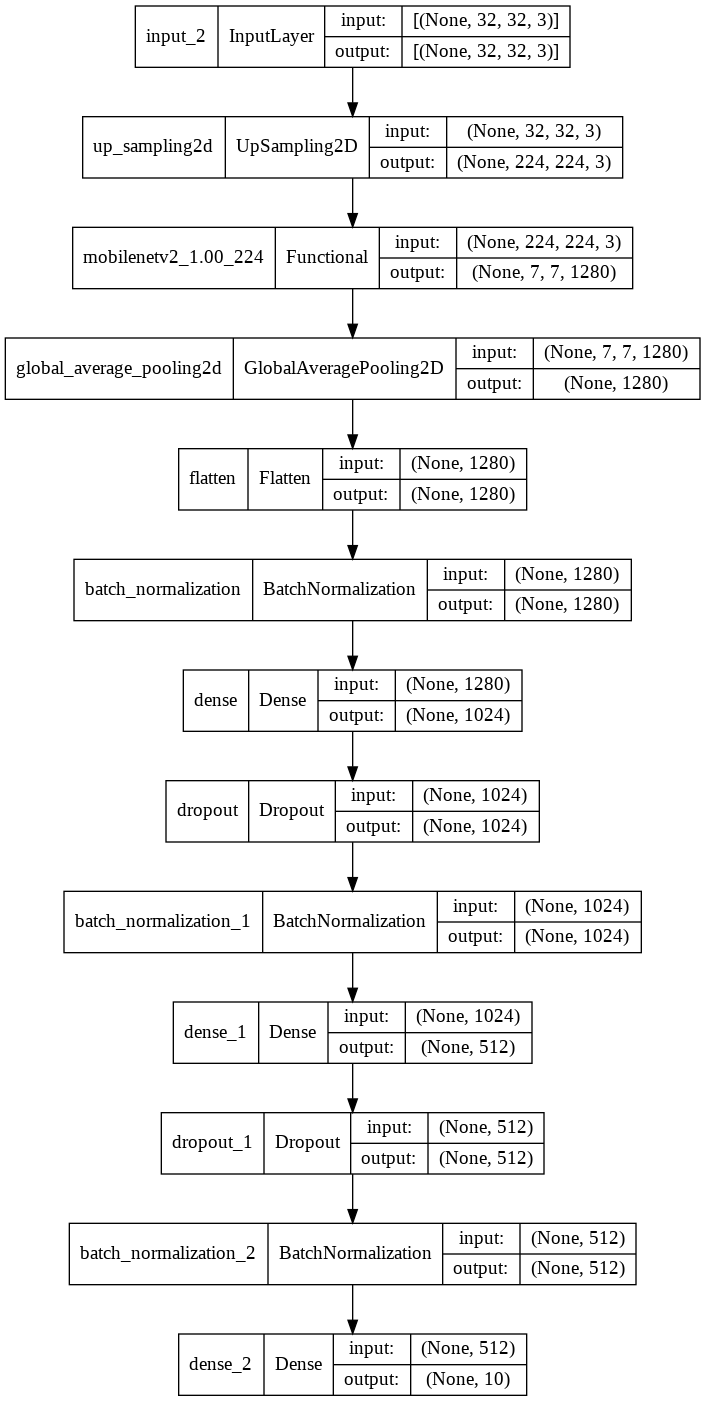

In [ ]:
# Plot model
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model_S.png')

In [ ]:
from tensorflow.keras import layers, models, callbacks

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobilenetV2S_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
epochs = 500
BATCH_SIZE = 32

history = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE), 
                 steps_per_epoch=x_train.shape[0]//BATCH_SIZE, 
                 epochs=epochs, verbose=1, 
                 callbacks=[mc_callback, es_callback], 
                 validation_data=(x_test,y_test))

# %%time
# history = model.fit(datagen.flow(x_train, y_train, batch_size=32), 
#                     epochs=500, batch_size=32, 
#                     validation_data=(x_test, y_test),
#                     callbacks=[mc_callback,es_callback])

Epoch 1/500
156/156 [==============================] - ETA: 0s - loss: 2.4256 - accuracy: 0.2319

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


156/156 [==============================] - 42s 244ms/step - loss: 2.4256 - accuracy: 0.2319 - val_loss: 1.6832 - val_accuracy: 0.4129
Epoch 2/500
156/156 [==============================] - 37s 238ms/step - loss: 1.9103 - accuracy: 0.3591 - val_loss: 1.5399 - val_accuracy: 0.4695
Epoch 3/500
156/156 [==============================] - 54s 350ms/step - loss: 1.7524 - accuracy: 0.3990 - val_loss: 1.5373 - val_accuracy: 0.4877
Epoch 4/500
156/156 [==============================] - 37s 239ms/step - loss: 1.6641 - accuracy: 0.4314 - val_loss: 1.4878 - val_accuracy: 0.5091
Epoch 5/500
156/156 [==============================] - 54s 351ms/step - loss: 1.5886 - accuracy: 0.4547 - val_loss: 1.4397 - val_accuracy: 0.5204
Epoch 6/500
156/156 [==============================] - 37s 238ms/step - loss: 1.5307 - accuracy: 0.4726 - val_loss: 1.4515 - val_accuracy: 0.5219
Epoch 7/500
156/156 [==============================] - 54s 351ms/step - loss: 1.4883 - accuracy: 0.4756 - val_loss: 1.4340 - val_accurac

In [ ]:
model.evaluate(x_test, y_test, batch_size=50)

200/200 [==============================] - 24s 117ms/step - loss: 1.1100 - accuracy: 0.7116


[1.1099646091461182, 0.7116000056266785]

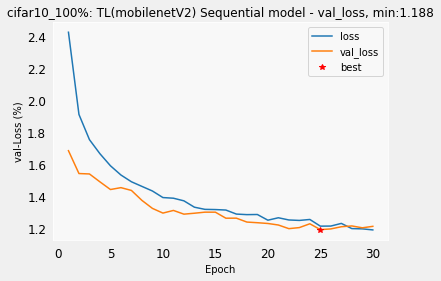

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 loss 시각화.
epochs = range(1, len(history.history['loss']) + 1)

loss_list = history.history['loss'] #[100 * i for i in history.history['loss']]
vloss_list = history.history['val_loss'] #[100 * i for i in history.history['val_loss']]

plt.plot(epochs,loss_list)  
plt.plot(epochs,vloss_list)

plt.plot(np.argmin(np.array(vloss_list))+1,vloss_list[np.argmin(np.array(vloss_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_loss, min:' + str(np.round(vloss_list[np.argmin(np.array(vloss_list))],3)))
plt.ylabel('val-Loss (%)')
plt.xlabel('Epoch')
plt.legend(['loss','val_loss','best'], loc='best')
plt.show()

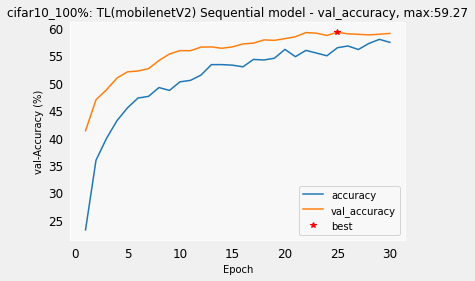

In [ ]:
# 훈련 데이터와 검증 데이터에 대한 accuracy 시각화.
epochs = range(1, len(history.history['accuracy']) + 1)

acc_list = [100 * i for i in history.history['accuracy']]
vacc_list = [100 * i for i in history.history['val_accuracy']]

plt.plot(epochs,acc_list)  
plt.plot(epochs,vacc_list)

plt.plot(np.argmax(np.array(vacc_list))+1,vacc_list[np.argmax(np.array(vacc_list))], 'r*')
plt.title('cifar10_100%: TL(mobilenetV2) Sequential model - val_accuracy, max:' + str(np.round(vacc_list[np.argmax(np.array(vacc_list))],3)))
plt.ylabel('val-Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['accuracy','val_accuracy','best'], loc='best')
plt.show()


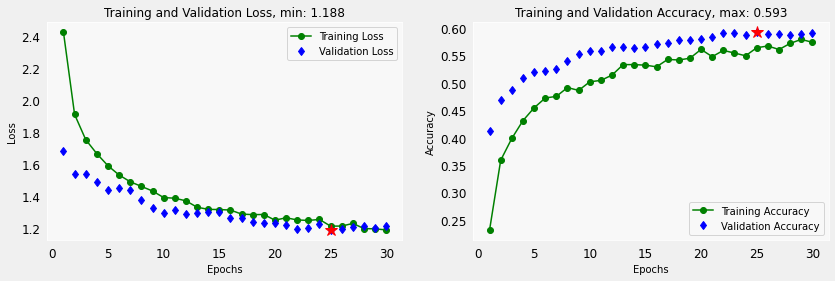

In [ ]:
# More graphs of loss and accuracy
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

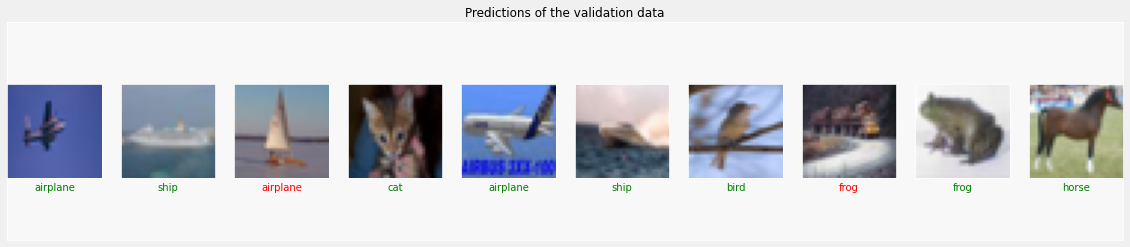

In [ ]:
probabilities = model.predict(x_test, batch_size=50)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")

In [ ]:
# Unfreeze all layers in base model
tf.keras.backend.clear_session()  # For memory
TL_base.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(TL_base.layers))

Number of layers in the base model:  154


In [ ]:
# Fine-tune from this layer onwards
fine_tune_at = 107  # 81, 107 for mobilenetV2

# Freeze all the layers before the `fine_tune_at` layer
for layer in TL_base.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# Compile model
model.compile(optimizer='SGD', 
                loss='categorical_crossentropy',  # sparse_categorical_crossentropy
                metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d (UpSampling2D  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                          

In [ ]:
mc_callback = callbacks.ModelCheckpoint(filepath="./model/cifar10_pct100_mobileNetV2S_FT_SGD_best_weights.{epoch:03d}-{val_accuracy:.4f}.hdf5", 
                              monitor='val_accuracy', verbose=0, save_best_only=True)
es_callback = callbacks.EarlyStopping(monitor='val_accuracy', 
                            mode='max', verbose=1, patience=5)

In [ ]:
INITIAL_EPOCHS = len(loss)
FINE_TUNE_EPOCHS = 500
TOTAL_EPOCHS = INITIAL_EPOCHS + FINE_TUNE_EPOCHS #

In [ ]:
history_fine = model.fit(datagen.flow(x_train, y_train, batch_size=32), 
                    epochs=TOTAL_EPOCHS, 
                    initial_epoch=INITIAL_EPOCHS,
                    batch_size=32, 
                    validation_data=(x_test, y_test),
                    callbacks=[mc_callback,es_callback])

Epoch 31/530
157/157 [==============================] - ETA: 0s - loss: 1.3603 - accuracy: 0.5174

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


157/157 [==============================] - 48s 280ms/step - loss: 1.3603 - accuracy: 0.5174 - val_loss: 1.8541 - val_accuracy: 0.4152
Epoch 32/530
157/157 [==============================] - 41s 264ms/step - loss: 1.0928 - accuracy: 0.6092 - val_loss: 1.4776 - val_accuracy: 0.5028
Epoch 33/530
157/157 [==============================] - 41s 263ms/step - loss: 0.9599 - accuracy: 0.6658 - val_loss: 1.3358 - val_accuracy: 0.5489
Epoch 34/530
157/157 [==============================] - 41s 265ms/step - loss: 0.8904 - accuracy: 0.6864 - val_loss: 1.4118 - val_accuracy: 0.5563
Epoch 35/530
157/157 [==============================] - 60s 381ms/step - loss: 0.8530 - accuracy: 0.6988 - val_loss: 1.3703 - val_accuracy: 0.5797
Epoch 36/530
157/157 [==============================] - 42s 267ms/step - loss: 0.7833 - accuracy: 0.7270 - val_loss: 1.7140 - val_accuracy: 0.5225
Epoch 37/530
157/157 [==============================] - 41s 262ms/step - loss: 0.7355 - accuracy: 0.7384 - val_loss: 1.2126 - val_a

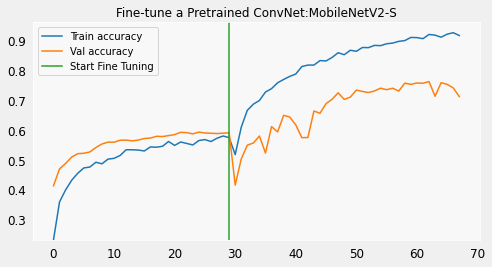

In [ ]:
# Display training curve

acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

plt.figure(figsize=(8, 4))

plt.plot(acc, label='Train accuracy')
plt.plot(val_acc, label='Val accuracy')
# plt.ylim([0.8, 1])
plt.plot([INITIAL_EPOCHS-1, INITIAL_EPOCHS-1], plt.ylim(ymin=acc[0]), label='Start Fine Tuning')
plt.title("Fine-tune a Pretrained ConvNet:MobileNetV2-S")
plt.legend(loc='upper left')

plt.show()

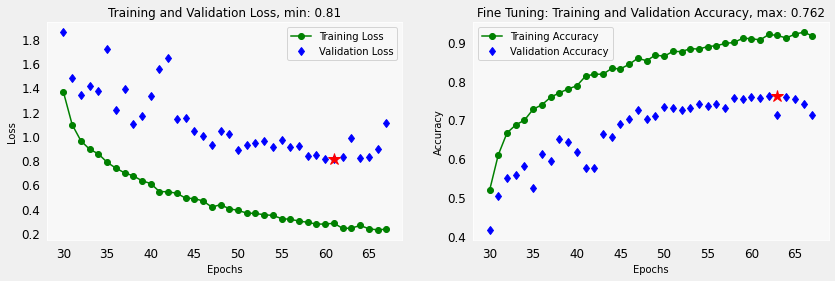

In [ ]:
# More graphs of loss and accuracy in Fine Tuning
history_dict = history_fine.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(INITIAL_EPOCHS, INITIAL_EPOCHS+len(loss))

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(INITIAL_EPOCHS + np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],3)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# epochs = range(1, len(loss_values) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy')#, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(INITIAL_EPOCHS + np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Fine Tuning: Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],3)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

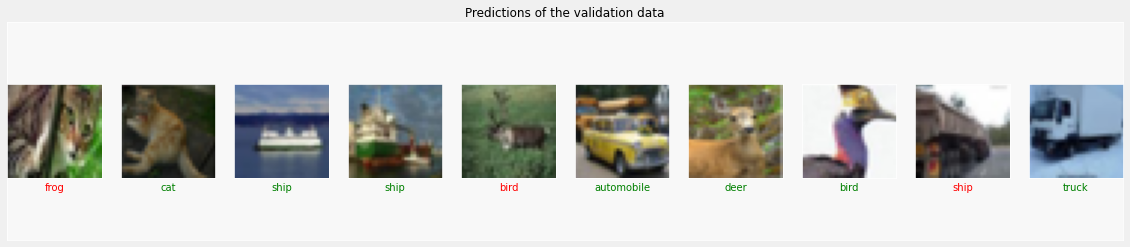

In [ ]:
probabilities = model.predict(x_test, batch_size=50)
probabilities = np.argmax(probabilities, axis = 1)

display_images(testX, probabilities, testy, "Predictions of the validation data")